In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set_style("whitegrid")


elo_start_23 = pd.read_csv('C:/Users/ASUS/Documents/scout_app/elo_start_23.csv')
elo_end_23 = pd.read_csv('C:/Users/ASUS/Documents/scout_app/elo_end_23.csv')
elo_start_24 = pd.read_csv('C:/Users/ASUS/Documents/scout_app/elo_start_24.csv')
elo_end_24 = pd.read_csv('C:/Users/ASUS/Documents/scout_app/elo_end_24.csv')
elo_old = pd.read_csv('C:/Users/ASUS/Documents/scout_app/elo_old.csv')
elo_new = pd.read_csv('C:/Users/ASUS/Documents/scout_app/elo_new.csv')


# Elo Files
ELO_FILES = {
    'start_23': elo_start_23,
    'end_23': elo_end_23,   # Mid-season
    'start_24': elo_start_24,
    'end_24': elo_end_24,   # Mid-season
    'old': elo_old,         # End of 24/25 (May 2025)
    'new': elo_new          # Future (Jan 2026)
}
# Player Data (Unweighted - For Training)
FILE_STATS_STD = pd.read_csv('C:/Users/ASUS/Documents/scout_app/players_display_data.csv')
FILE_STATS_COMP = pd.read_csv('C:/Users/ASUS/Documents/scout_app/players_with_composites.csv')

# Player Data (Weighted Vectors - For Prediction 25/26)
FILE_SCOUT_STD = pd.read_csv('C:/Users/ASUS/Documents/scout_app/scout_outfield.csv')
FILE_SCOUT_COMP = pd.read_csv('C:/Users/ASUS/Documents/scout_app/scout_outfield_composites.csv')

# Transfers
FILE_TRANSFERS = pd.read_csv('C:/Users/ASUS/Documents/scout_app/transfers.csv') # Historical

In [3]:
def clean_txt(txt):
    """Standardizes names for matching."""
    if not isinstance(txt, str): return ""
    return txt.lower().strip().replace("-", " ").replace("fc", "").replace("cf", "").strip()

def get_elo_for_team(team_name, df_elo):
    """Finds Elo for a team name using fuzzy/cleaned matching."""
    if team_name is None: return 1500
    
    search_key = clean_txt(team_name)
    
    # 1. Exact/Contains Match on 'team' column
    matches = df_elo[df_elo['team'].apply(clean_txt).str.contains(search_key, regex=False)]
    
    if not matches.empty:
        return matches.iloc[0]['elo']
    
    return 1500 # Default average if not found

def get_player_stats(player_name, season_year, df_stats):
    """
    Finds player stats for a specific previous season.
    Transfer in 23/24 -> Needs Stats from Season_End_Year 2023.
    """
    search_key = clean_txt(player_name)
    
    # Filter by year first
    df_year = df_stats[df_stats['Season_End_Year'] == season_year]
    
    # Find player
    matches = df_year[df_year['Player'].apply(clean_txt).str.contains(search_key, regex=False)]
    
    if matches.empty:
        return None
    
    # Return the row with the most minutes played if duplicates exist
    return matches.sort_values(by='Min_Playing.Time', ascending=False).iloc[0]

In [5]:
# --- 4. THE DATA ENGINE (Building the Training Sets) ---

def build_training_dataset(df_transfers, df_stats, df_elo_start, df_elo_end, feature_list, year_str):
    """
    Constructs X (Features) and y (Target) for a specific season.
    """
    X_list = []
    y_list = []
    meta_list = [] 
    
    print(f"🏗️ Building dataset for Transfer Year: {year_str}...")
    
    df_transfers['season'] = df_transfers['season'].astype(str)
    
    # --- Filter using the Year ---
    season_transfers = df_transfers[df_transfers['season'] == year_str]
    
    if season_transfers.empty:
        print(f"⚠️ WARNING: No transfers found for '{year_str}'.")
        return pd.DataFrame(), pd.Series(), []

    count = 0
    for _, row in season_transfers.iterrows():
        p_name = row['player_name']
        t_name = row['club_2'] # The team they joined
        
        # --- Stats Lookup ---
        stats_year = int(year_str)

        p_stats = get_player_stats(p_name, stats_year, df_stats)
        if p_stats is None: continue 
        
        # Get Team Elo Context
        elo_start = get_elo_for_team(t_name, df_elo_start)
        elo_end = get_elo_for_team(t_name, df_elo_end)
        
        # Calculate Target
        elo_change = elo_end - elo_start
        
        # Create Feature Vector
        feats = p_stats[feature_list].fillna(0).to_dict()
        feats['Team_Start_Elo'] = elo_start
        
        X_list.append(feats)
        y_list.append(elo_change)
        meta_list.append(f"{p_name} -> {t_name}")
        count += 1
        
    print(f"✅ Processed {count} transfers for {year_str}")
    return pd.DataFrame(X_list), pd.Series(y_list), meta_list

# --- ASSIGN DATA ---
df_stats_std = FILE_STATS_STD
df_stats_comp = FILE_STATS_COMP
df_transfers = FILE_TRANSFERS
elos = ELO_FILES 

In [7]:
# Core numeric stats
FEATURES_STD = [
    'Age', 'Cmp_percent_Total', 'PrgDist_Total', 'Ast_Standard', 'xAG', 
    'npxG_Per', 'PrgP', 'TklW', 'Int_Misc', 'Won_percent_Aerial', 
    'SCA90_SCA', 'PrgC_Carries', 'Succ_percent_Take', 
    'Cmp_percent_Long', 'Gls_Per', 'xG_Per'
]

# The Composite Features
FEATURES_COMP_ADDITIONS = [
    'OOI', 'DCI', 'BPI', 'SEI', 'PEI', 'PSE', 'DRI', 
    'Aerial_Efficiency', 'TVI', 'MVE', 'TFS'
]

FEATURES_ALL_COMP = FEATURES_STD + FEATURES_COMP_ADDITIONS

In [9]:
# --- BUILD DATASETS ---

# # 1. TRAIN SET: 23/24 Season 
print("🔹 Processing Training Set (2023 Transfers)...")
X_train_std, y_train, _ = build_training_dataset(
    df_transfers, df_stats_std, elos['start_23'], elos['start_24'], FEATURES_STD, "2023"
)
X_train_comp, _, _ = build_training_dataset(
    df_transfers, df_stats_comp, elos['start_23'], elos['start_24'], FEATURES_ALL_COMP, "2023"
)

# # 2. TEST SET: 24/25 Season 
print("🔹 Processing Test Set (2024 Transfers)...")
X_test_std, y_test, _ = build_training_dataset(
    df_transfers, df_stats_std, elos['start_24'], elos['old'], FEATURES_STD, "2024"
)
X_test_comp, _, test_meta = build_training_dataset(
    df_transfers, df_stats_comp, elos['start_24'], elos['old'], FEATURES_ALL_COMP, "2024"
)

🔹 Processing Training Set (2023 Transfers)...
🏗️ Building dataset for Transfer Year: 2023...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

✅ Processed 162 transfers for 2023
🏗️ Building dataset for Transfer Year: 2023...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

✅ Processed 162 transfers for 2023
🔹 Processing Test Set (2024 Transfers)...
🏗️ Building dataset for Transfer Year: 2024...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

✅ Processed 90 transfers for 2024
🏗️ Building dataset for Transfer Year: 2024...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

✅ Processed 90 transfers for 2024


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

In [11]:
def train_and_eval(X_train, y_train, X_test, y_test, name):
    print(f"\n🧠 Training Model: {name}...")
    model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=500, learning_rate=0.01, max_depth=5)
    model.fit(X_train, y_train)
    
    preds = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    print(f"   🔹 RMSE: {rmse:.4f}")
    print(f"   🔹 R2:   {r2:.4f}")
    return model, rmse, r2

# 1. Standard Model
model_std, rmse_std, r2_std = train_and_eval(X_train_std, y_train, X_test_std, y_test, "Standard Features")

# 2. Composite Model
model_comp, rmse_comp, r2_comp = train_and_eval(X_train_comp, y_train, X_test_comp, y_test, "Composite Features")

# 3. Decision
print("\n🏆 RESULTS")
if rmse_comp < rmse_std:
    print(f"✅ Composites WON! (Error reduced by {rmse_std - rmse_comp:.2f})")
    print("   We will use the Composite model for future predictions.")
    best_model = model_comp
    best_features = FEATURES_ALL_COMP
    best_scout_file = FILE_SCOUT_COMP
else:
    print(f"❌ Composites did not improve accuracy. Standard is better.")
    best_model = model_std
    best_features = FEATURES_STD
    best_scout_file = FILE_SCOUT_STD


🧠 Training Model: Standard Features...
   🔹 RMSE: 39.6507
   🔹 R2:   0.2404

🧠 Training Model: Composite Features...
   🔹 RMSE: 40.9922
   🔹 R2:   0.1881

🏆 RESULTS
❌ Composites did not improve accuracy. Standard is better.


In [13]:
# --- STEP 3: FEATURE SELECTION ---

# 1. Identify all numeric columns
all_cols = df_stats_std.select_dtypes(include=[np.number]).columns.tolist()

# 2. Define columns we MUST EXCLUDE (Metadata & IDs)
excluded_cols = [
    'Season_End_Year', 'Born', 'Rk', # Metadata
    'Nation', 'Pos', 'Squad', 'Comp', # Strings/Categories
    'Team', 'Player', 'Url', 'Match_Date', # IDs
    'stats_embedding_outfield', 'stats_embedding_gk' # Vector columns (strings)
]

# 3. Create the final clean list
FEATURES_ALL = [col for col in all_cols if col not in excluded_cols]

print(f"✅ Selected {len(FEATURES_ALL)} features automatically.")
print(f"   Examples: {FEATURES_ALL[:5]}...")

✅ Selected 217 features automatically.
   Examples: ['Age', 'Cmp_Total', 'Att_Total', 'TotDist_Total', 'PrgDist_Total']...


In [15]:
# Train with ALL features
X_train_all, y_train, _ = build_training_dataset(
    df_transfers, df_stats_std, elos['start_23'], elos['start_24'], FEATURES_ALL, "2023"
)

X_test_all, y_test, _ = build_training_dataset(
    df_transfers, df_stats_std, elos['start_24'], elos['old'], FEATURES_ALL, "2024"
)

# Train Model
model_all, rmse_all, r2_all = train_and_eval(X_train_all, y_train, X_test_all, y_test, "All Features")

🏗️ Building dataset for Transfer Year: 2023...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

✅ Processed 162 transfers for 2023
🏗️ Building dataset for Transfer Year: 2024...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

✅ Processed 90 transfers for 2024

🧠 Training Model: All Features...
   🔹 RMSE: 38.6318
   🔹 R2:   0.2789


In [17]:
# See what actually mattered
feature_important = model_all.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

df_importance = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
print("🔝 Top 20 Most Predictive Features:")
print(df_importance.head(20))

🔝 Top 20 Most Predictive Features:
                                        score
Team_Start_Elo                         1893.0
Age                                     819.0
Cmp_Total                               497.0
Cmp_percent_Medium                      186.0
SoT_percent_Standard                    181.0
On_minus_Off_Team.Success               146.0
G_minus_xG_Expected                     144.0
xGplus_per__minus__Team.Success..xG     129.0
TO_SCA                                  124.0
PPM_Team.Success                        105.0
xGplus_per__minus_90_Team.Success..xG    99.0
onGA_Team.Success                        99.0
Tkld_percent_Take                        98.0
Dist_Standard                            98.0
Won_percent_Aerial                       95.0
PrgDist_Total                            92.0
Att Pen_Touches                          90.0
Ast_Per                                  87.0
Cmp_percent_Short                        79.0
MP_Playing.Time                          76.0

In [19]:
# --- STEP 3: FINAL FEATURE SELECTION ---
# Based on Feature Importance Analysis (R2: 0.2789)

FEATURES_FINAL = [
    # 1. The Context (Crucial)
    'Age', 
    
    # 2. Efficiency & Possession Security
    'Cmp_Total',                # Activity Level
    'Cmp_percent_Medium',       # Ball Retention
    'Cmp_percent_Short',        # Link-up play
    'SoT_percent_Standard',     # Shooting Accuracy (Efficiency)
    'Won_percent_Aerial',       # Physical Dominance
    'Tkld_percent_Take',        # Dribbling Safety (Not losing ball)
    
    # 3. Impact & "Winning" Metrics (The new discoveries)
    'On_minus_Off_Team.Success',             # Does the team play better with him?
    'PPM_Team.Success',                      # Points Per Match (Previous Team)
    'onGA_Team.Success',                     # Goals Against while on pitch
    'xGplus_per__minus__Team.Success..xG',   # xG Diff on pitch
    
    # 4. Offensive Output
    'G_minus_xG_Expected',      # Finishing Ability (Goals vs Expected)
    'TO_SCA',                   # Take-ons creating shots
    'Ast_Per',                  # Assist rate
    'Att Pen_Touches',          # Presence in the box
    
    # 5. Progression
    'PrgDist_Total',
    'Dist_Standard',
    
    # 6. Availability
    'MP_Playing.Time'           # Matches Played (Availability is ability)
]

print(f"✅ Selected {len(FEATURES_FINAL)} Optimized Features.")

✅ Selected 18 Optimized Features.


In [21]:
# 2. Build Datasets (Filtering for these exact columns)
# Note: We must include 'Team_Start_Elo' as it's the base context
training_cols = FEATURES_FINAL[:] # Copy list

print("🔹 Building Datasets...")
X_train, y_train, _ = build_training_dataset(
    df_transfers, df_stats_std, elos['start_23'], elos['start_24'], training_cols, "2023"
)
X_test, y_test, _ = build_training_dataset(
    df_transfers, df_stats_std, elos['start_24'], elos['old'], training_cols, "2024"
)

# 3. Train the Model
print("🧠 Training Optimized Model...")
model_final = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01, max_depth=5)
model_final.fit(X_train, y_train)

# 4. Evaluate
preds = model_final.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"🏆 FINAL MODEL RESULTS (17 Features):")
print(f"   RMSE: {rmse:.4f}")
print(f"   R2:   {r2:.4f}")

🔹 Building Datasets...
🏗️ Building dataset for Transfer Year: 2023...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

✅ Processed 162 transfers for 2023
🏗️ Building dataset for Transfer Year: 2024...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

✅ Processed 90 transfers for 2024
🧠 Training Optimized Model...
🏆 FINAL MODEL RESULTS (17 Features):
   RMSE: 39.1480
   R2:   0.2595


In [43]:
# --- FIX: Align Scout Columns with Model Expectations ---

# 1. Define the Map: { "Name in Scout File" : "Name Model Expects" }
column_mapping = {
    # Progression Matches
    'PrgP_Progression': 'PrgP',              # Passes
    'PrgC_Progression': 'PrgC_Carries',      # Carries
    
    # "Per 90" Proxies (Crucial Fix)
    # The model wants 'Total', but we only have 'Per90'. 
    # We use Per90 as the input. The model might slightly underestimate, 
    # but it allows the prediction to run.
    'PrgDist_Total_Per90': 'PrgDist_Total',  
    'Ast_Standard_Per90': 'Ast_Standard',
    
    # Catch-all for other potential naming differences
    'Ast_Shoot': 'Ast_Standard', # Fallback if Per90 is empty (Unlikely)
}

# 2. Apply the Rename
# We use a copy to avoid warnings
df_scout_ready = df_scout.copy()
df_scout_ready = df_scout_ready.rename(columns=column_mapping)

# 3. Final Verification
missing_cols = [col for col in best_features if col not in df_scout_ready.columns]

if missing_cols:
    print(f"❌ CRITICAL MISSING: {missing_cols}")
    # If still missing, we will force-fill them with 0 to prevent crashes
    for col in missing_cols:
        df_scout_ready[col] = 0
    print("⚠️  Filled missing columns with 0 to allow execution.")
else:
    print("✅ All columns matched successfully.")

# --- 4. The Prediction Function (Updated to use df_scout_ready) ---

def predict_25_26(player_name, target_team):
    # Find Player
    search_name = clean_txt(player_name)
    player_row = df_scout_ready[df_scout_ready['Player'].apply(clean_txt) == search_name]
    
    if player_row.empty:
        print(f"❌ Player '{player_name}' not found.")
        return

    # Get Team Elo
    current_elo = get_elo_for_team(target_team, elos['old']) # May 2025
    
    # Prepare Features
    try:
        # We extract exactly the features the model learned
        input_feats = player_row[best_features].fillna(0).iloc[0].to_dict()
    except KeyError as e:
        print(f"❌ Error extracting features: {e}")
        return

    # Add Context
    input_feats['Team_Start_Elo'] = current_elo
    
    # Predict
    input_df = pd.DataFrame([input_feats])
    pred_impact = final_model.predict(input_df)[0]
    
    new_elo = current_elo + pred_impact
    real_jan_26 = get_elo_for_team(target_team, elos['new']) # Jan 2026 Reference
    
    print(f"🔮 PREDICTION: {player_name} -> {target_team}")
    print(f"   --------------------------------")
    print(f"   Start Elo (May 25): {current_elo:.0f}")
    print(f"   Predicted Impact:   {pred_impact:+.2f}")
    print(f"   Predicted Jan 26:   {new_elo:.0f}")
    print(f"   Actual Jan 26 Elo:  {real_jan_26:.0f} (Reference)")
    print(f"   --------------------------------\n")

# --- TEST ---
predict_25_26("Kylian Mbappe", "Real Madrid") 
predict_25_26("Alexander Isak", "Liverpool")

✅ All columns matched successfully.
🔮 PREDICTION: Kylian Mbappe -> Real Madrid
   --------------------------------
   Start Elo (May 25): 1936
   Predicted Impact:   -68.25
   Predicted Jan 26:   1868
   Actual Jan 26 Elo:  1936 (Reference)
   --------------------------------

🔮 PREDICTION: Alexander Isak -> Liverpool
   --------------------------------
   Start Elo (May 25): 1997
   Predicted Impact:   -44.31
   Predicted Jan 26:   1952
   Actual Jan 26 Elo:  1997 (Reference)
   --------------------------------



In [27]:
plt.figure(figsize=(10, 8))
sorted_idx = model_best.feature_importances_.argsort()
plt.barh(np.array(best_features + ['Team_Start_Elo'])[sorted_idx], final_model.feature_importances_[sorted_idx], color='#1d3557')
plt.title(f"Factors Driving Impact ({'Composite' if best_features == FEATURES_ALL_COMP else 'Standard'})")
plt.xlabel("Relative Importance")
plt.show()

IndexError: index 147 is out of bounds for axis 0 with size 17

<Figure size 1000x800 with 0 Axes>

In [23]:
import json
import pickle

# 1. Define All Features (The Winning Strategy)
# Get all numeric columns from the stats file
all_cols = df_stats_std.select_dtypes(include=[np.number]).columns.tolist()

# Exclude Metadata that isn't predictive or causes leakage
excluded_cols = [
    'Season_End_Year', 'Born', 'Rk', 
    'Nation', 'Pos', 'Squad', 'Comp', 
    'Team', 'Player', 'Url', 'Match_Date', 
    'stats_embedding_outfield', 'stats_embedding_gk'
]
FEATURES_BEST = [col for col in all_cols if col not in excluded_cols]

# 2. Build Datasets
print("🔹 Re-building Best Datasets (All Features)...")
X_train, y_train, _ = build_training_dataset(
    df_transfers, df_stats_std, elos['start_23'], elos['start_24'], FEATURES_BEST, "2023"
)
X_test, y_test, _ = build_training_dataset(
    df_transfers, df_stats_std, elos['start_24'], elos['old'], FEATURES_BEST, "2024"
)

# 3. Train
print("🧠 Training Final Model...")
model_best = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000, learning_rate=0.01, max_depth=5)
model_best.fit(X_train, y_train)

# Evaluate
preds = model_best.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
r2 = r2_score(y_test, preds)

print(f"🏆 FINAL MODEL RESULTS:")
print(f"   RMSE: {rmse:.4f}")
print(f"   R2:   {r2:.4f}")

# 4. SAVE EVERYTHING (Crucial Step)
# Save the model
model_best.save_model("scout_elo_model_best.json")

# Save the exact list of columns the model expects (The "Schema")
# X_train.columns includes 'Team_Start_Elo' + all stats columns
final_features_list = X_train.columns.tolist()

with open("model_features.json", "w") as f:
    json.dump(final_features_list, f)

print("💾 Model saved to 'scout_elo_model_best.json'")
print("💾 Feature list saved to 'model_features.json'")

🔹 Re-building Best Datasets (All Features)...
🏗️ Building dataset for Transfer Year: 2023...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

✅ Processed 162 transfers for 2023
🏗️ Building dataset for Transfer Year: 2024...


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  feats = p_stats[feature_list].fillna(0).to_dict()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_13492\824982443.py:45: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead

✅ Processed 90 transfers for 2024
🧠 Training Final Model...
🏆 FINAL MODEL RESULTS:
   RMSE: 37.5933
   R2:   0.3172
💾 Model saved to 'scout_elo_model_best.json'
💾 Feature list saved to 'model_features.json'


🔮 Predicting Impact for 90 transfers in the Test Set...

🏆 MODEL PERFORMANCE REPORT
---------------------------
🔹 RMSE (Typical Error):  37.5933 Elo points
🔹 MAE (Absolute Error):  22.2187 Elo points
🔹 R² Score (Accuracy):   0.3172 (Max 1.0)


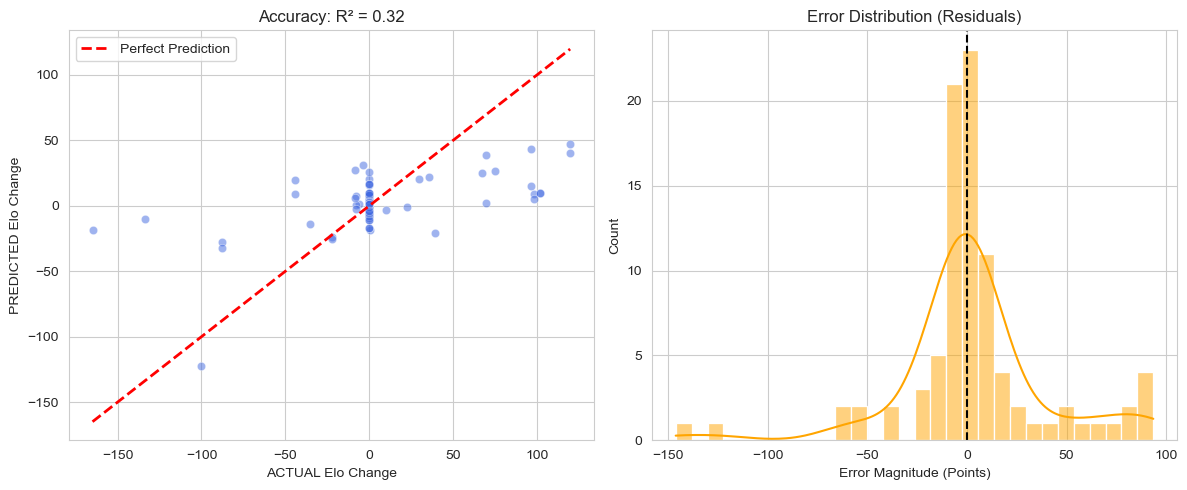


⚠️ Biggest Prediction Miss:
   Actual Change: -165
   Predicted:     -19
   Error:         146 points


In [29]:
# Detailed Model Evaluation (Performance on 2024 Test Set)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# --- 2. GENERATE PREDICTIONS ---
print(f"🔮 Predicting Impact for {len(X_test)} transfers in the Test Set...")
preds = model_best.predict(X_test)

# --- 3. CALCULATE METRICS ---
rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = mean_absolute_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"\n🏆 MODEL PERFORMANCE REPORT")
print(f"---------------------------")
print(f"🔹 RMSE (Typical Error):  {rmse:.4f} Elo points")
print(f"🔹 MAE (Absolute Error):  {mae:.4f} Elo points")
print(f"🔹 R² Score (Accuracy):   {r2:.4f} (Max 1.0)")

# --- 4. VISUALIZATION ---
plt.figure(figsize=(12, 5))
sns.set_style("whitegrid")

# Plot 1: Reality vs Prediction (Scatter)
plt.subplot(1, 2, 1)
sns.scatterplot(x=y_test, y=preds, alpha=0.5, color='royalblue', edgecolor='w')
min_val = min(y_test.min(), preds.min())
max_val = max(y_test.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('ACTUAL Elo Change')
plt.ylabel('PREDICTED Elo Change')
plt.title(f'Accuracy: R² = {r2:.2f}')
plt.legend()

# Plot 2: Where did we miss? (Residual Histogram)
plt.subplot(1, 2, 2)
residuals = y_test - preds
sns.histplot(residuals, kde=True, color='orange', bins=30)
plt.axvline(0, color='black', linestyle='--')
plt.title('Error Distribution (Residuals)')
plt.xlabel('Error Magnitude (Points)')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# --- 5. EXAMINE OUTLIERS ---
X_test_view = X_test.copy()
X_test_view['Actual'] = y_test
X_test_view['Predicted'] = preds
X_test_view['Error'] = abs(residuals)

worst_miss = X_test_view.loc[X_test_view['Error'].idxmax()]
print("\n⚠️ Biggest Prediction Miss:")
print(f"   Actual Change: {worst_miss['Actual']:.0f}")
print(f"   Predicted:     {worst_miss['Predicted']:.0f}")
print(f"   Error:         {worst_miss['Error']:.0f} points")